In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Recent date: {recent_date[0]}")

Recent date: 2017-08-23


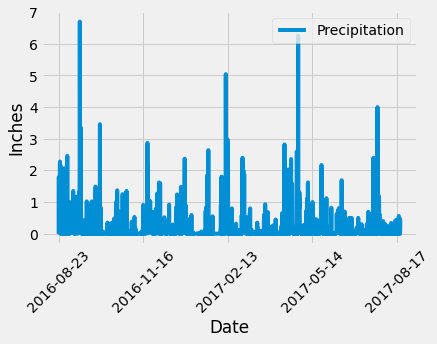

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydate = dt.date(recent_date.year -1, recent_date.month, recent_date.day)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(queryresult, columns=['Date','Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["Date"], ascending = True).dropna()
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.savefig("Precipitation_Hawaii.png")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe().round(4)

,Precipitation
count,2021.0000
mean,0.1773
std,0.4612
min,0.0000
25%,0.0000
50%,0.0200
75%,0.1300
max,6.7000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.id).count()
stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, Station.name, func.count(Measurement.id)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all())
print(active_stations)

[('USC00519281', 'WAIHEE 837.5, HI US', 2772), ('USC00519397', 'WAIKIKI 717.2, HI US', 2724), ('USC00513117', 'KANEOHE 838.1, HI US', 2709), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979), ('USC00517948', 'PEARL CITY, HI US', 1372), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
record = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs),).filter(Measurement.station == active_stations[0][0]).all())
print(f"The most active station ID is {active_stations[0][0]} - {active_stations[0][1]}")
print(f"The lowest temperature is {record[0][0]}F, the highest temperature is {record[0][1]}F, and the average temperature {record[0][2]}F")

The most active station ID is USC00519281 - WAIHEE 837.5, HI US
The lowest temperature is 54.0F, the highest temperature is 85.0F, and the average temperature 71.66378066378067F


In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
temperature_analysis = (session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date > last_year).filter(Measurement.station == active_stations[0][0]).order_by(Measurement.date).all())

#Create dataframe
temperature_df = pd.DataFrame(temperature_analysis, columns=['Station', 'Date', 'Temperature'])
temperature_df = temperature_df.set_index("Date").sort_index(ascending=True)
temperature_df



,Station,Temperature
Date,,
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0
2016-08-28,USC00519281,73.0
...,...,...
2017-08-14,USC00519281,77.0
2017-08-15,USC00519281,77.0
2017-08-16,USC00519281,76.0


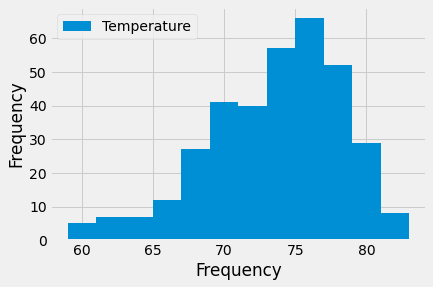

In [16]:
temperature_df.plot(kind="hist", bins = 12)
plt.xlabel("Temperature")
plt.xlabel("Frequency")
plt.savefig("stations_temperature.png")

# Close session

In [17]:
# Close Session
session.close()